In [7]:
# Install necessary libraries
!pip install tensorflow keras

In [1]:
import os
import numpy as np
import tensorflow as tf
import shutil
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.utils.class_weight import compute_class_weight
import cv2


In [2]:
# Define paths
original_data_dir = "D:/CW/FYP/Axial"
base_dir = "D:/CW/FYP/Axial Dataset split"
train_dir = os.path.join(base_dir, "Train")
val_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")


In [3]:
# Ensure the dataset folders exist
for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(folder, exist_ok=True)

In [4]:
# Classes
categories = ["AS Diganosis", "No AS Diganosis"]

In [11]:
# # Shuffle and split data
# for category in categories:
#     class_path = os.path.join(original_data_dir, category)
#     images = os.listdir(class_path)
#     random.shuffle(images)  # Shuffle images

#     train_images = images[:800]
#     val_images = images[800:900]
#     test_images = images[900:1000]

#     for dataset, dataset_images in zip([train_dir, val_dir, test_dir], [train_images, val_images, test_images]):
#         class_subdir = os.path.join(dataset, category)
#         os.makedirs(class_subdir, exist_ok=True)
#         for image in dataset_images:
#             shutil.copy(os.path.join(class_path, image), os.path.join(class_subdir, image))

In [9]:
# Image properties
img_height = 224
img_width = 224
batch_size = 32

In [11]:
# Preprocessing function (CLAHE contrast enhancement)
def enhance_image(img):
    if len(img.shape) == 3 and img.shape[-1] == 3:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.uint8(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_GRAY2RGB)
    return enhanced_img.astype(np.float32)

In [13]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=enhance_image
)
val_test_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=enhance_image
)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [19]:
# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True

In [21]:
# Freeze initial layers
for layer in base_model.layers[:10]:
    layer.trainable = False

In [23]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [25]:
# Define model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [33]:
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

In [35]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [37]:
# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=50,
    callbacks=callbacks,
    #class_weight=class_weights
)

D:\New folder\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 596s 12s/step - accuracy: 0.4739 - auc: 0.4547 - loss: 1.4712 - precision: 0.4724 - recall: 0.5508 - val_accuracy: 0.6562 - val_auc: 0.6971 - val_loss: 1.3175 - val_precision: 0.6321 - val_recall: 0.7128 - learning_rate: 1.0000e-05
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 618s 12s/step - accuracy: 0.5476 - auc: 0.5659 - loss: 1.3539 - precision: 0.5411 - recall: 0.5767 - val_accuracy: 0.6406 - val_auc: 0.7224 - val_loss: 1.2871 - val_precision: 0.6116 - val_recall: 0.7708 - learning_rate: 1.0000e-05
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 632s 13s/step - accuracy: 0.6084 - auc: 0.6449 - loss: 1.3041 - precision: 0.6048 - recall: 0.5967 - val_accuracy: 0.6719 - val_auc: 0.7348 - val_loss: 1.2420 - val_precision: 0.7125 - val_recall: 0.5876 - learning_rate: 1.0000e-05
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 633s 13s/step - accuracy: 0.6017 - auc: 0.6580 - loss: 1.2734 - precision: 0.6024 - recall: 0.5961 - val_accuracy: 0.6927 - val_auc: 0.7668 - val_loss: 

In [39]:
# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Precision: {test_precision:.2f}")
print(f"Test Recall: {test_recall:.2f}")
print(f"Test AUC: {test_auc:.2f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.7978 - auc: 0.5720 - loss: 1.0209 - precision: 0.4321 - recall: 0.5696    
Test Accuracy: 80.50%
Test Precision: 0.77
Test Recall: 0.88
Test AUC: 0.89


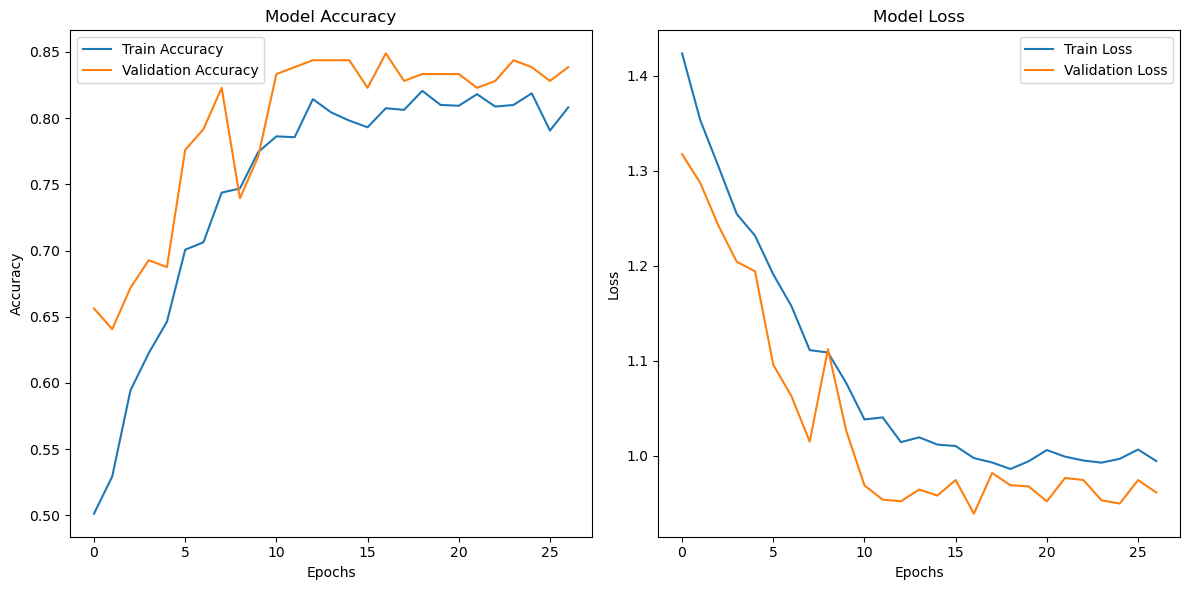

In [43]:
import matplotlib.pyplot as plt
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
# Save the final model
model.save("D:/Final Year/FYP/ankylosing_spondylitis_vgg16_model_Final_2.keras")


In [15]:
from keras.models import load_model
saved_model = load_model('D:/Final Year/FYP/ankylosing_spondylitis_vgg16_model_Final_2.keras')

In [25]:
prediction_VGG16 = saved_model.predict(test_generator) 

7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step


In [27]:
prediction_VGG16

array([[0.16693072],
       [0.4494785 ],
       [0.0996934 ],
       [0.07207481],
       [0.08517908],
       [0.15645123],
       [0.14211202],
       [0.6938627 ],
       [0.22183824],
       [0.48247004],
       [0.42031085],
       [0.18906246],
       [0.11403557],
       [0.2569486 ],
       [0.02906567],
       [0.21979426],
       [0.19730352],
       [0.6053656 ],
       [0.41966918],
       [0.08677176],
       [0.0766032 ],
       [0.10140739],
       [0.06871036],
       [0.02615514],
       [0.0533544 ],
       [0.03470376],
       [0.7156    ],
       [0.02488562],
       [0.12700231],
       [0.09565222],
       [0.05191758],
       [0.08117003],
       [0.09699524],
       [0.0283642 ],
       [0.87089056],
       [0.9346168 ],
       [0.54186463],
       [0.80798966],
       [0.06860929],
       [0.09780506],
       [0.04337105],
       [0.95469016],
       [0.9261589 ],
       [0.93849874],
       [0.27363053],
       [0.6956008 ],
       [0.6925005 ],
       [0.882

In [29]:
len(prediction_VGG16)

200

In [33]:
 xx=np.argmax(prediction_VGG16,axis=1)
xx

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [22]:
prediction_VGG16

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix , f1_score

# Get true labels
true_labels = test_generator.classes

# Get predicted labels (Apply threshold 0.5 since it's binary classification)
predicted_labels = (prediction_VGG16 > 0.5).astype(int)

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=["No AS Diagnosis", "AS Diagnosis"])

# Print classification report
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
                  precision    recall  f1-score   support

No AS Diagnosis       0.86      0.73      0.79       100
   AS Diagnosis       0.77      0.88      0.82       100

       accuracy                           0.81       200
      macro avg       0.81      0.80      0.80       200
   weighted avg       0.81      0.81      0.80       200

Confusion Matrix:
 [[73 27]
 [12 88]]


In [ ]:
# plot confusion metric


In [57]:
# Define class names
class_names = ["No AS Diagnosis", "AS Diagnosis"]

In [61]:
from keras.models import load_model

load_imagePath = 'D:/Final Year/FYP/Dataset 1/Axial/Testing Dataset/AS diagnosis/sass (901).png'
saved_model = load_model('D:/Final Year/FYP/ankylosing_spondylitis_vgg16_model_Final_2.keras')

<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
[[1.3565802e-05]]
Classification:  No AS Diagnosis
Value 1.3565802e-05


C:\Users\ASUS ZenBook\AppData\Local\Temp\ipykernel_8676\1382370381.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Classification: ",class_names[int(np.argmax(result,axis=1))])


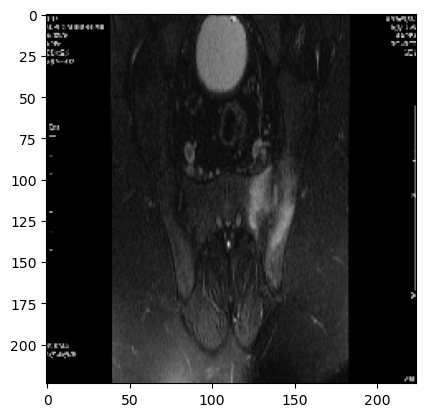

In [63]:
from keras.preprocessing import image

test_img = image.load_img(load_imagePath, target_size=(224, 224))  # Assuming your model uses 224x224 images
test_image = image.img_to_array(test_img)
test_image = np.expand_dims(test_image, axis = 0)
print(type(test_image))    
result = saved_model.predict(test_image)
print(result)
plt.imshow(test_img) 
print("Classification: ",class_names[int(np.argmax(result,axis=1))])
print("Value", np.amax(result))

In [67]:
# Predict and classify test images
predictions = saved_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype(int)

6/7 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step WARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000015BFEFD6A20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step


In [69]:
# Map predicted classes to Yes/No for Ankylosing Spondylitis
def class_to_label(pred):
    return "Yes" if pred == 0 else "No"

predicted_labels = [class_to_label(pred[0]) for pred in predicted_classes]

In [71]:
# Display predictions
for i, filename in enumerate(test_generator.filenames):
    print(f"Image: {filename}, Predicted: {predicted_labels[i]}")

Image: AS Diganosis\sass (13).png, Predicted: Yes
Image: AS Diganosis\sass (133).png, Predicted: Yes
Image: AS Diganosis\sass (165).png, Predicted: Yes
Image: AS Diganosis\sass (166).png, Predicted: Yes
Image: AS Diganosis\sass (17).png, Predicted: Yes
Image: AS Diganosis\sass (187).png, Predicted: Yes
Image: AS Diganosis\sass (19).png, Predicted: Yes
Image: AS Diganosis\sass (195).png, Predicted: No
Image: AS Diganosis\sass (203).png, Predicted: Yes
Image: AS Diganosis\sass (206).png, Predicted: Yes
Image: AS Diganosis\sass (21).png, Predicted: Yes
Image: AS Diganosis\sass (234).png, Predicted: Yes
Image: AS Diganosis\sass (237).png, Predicted: Yes
Image: AS Diganosis\sass (240).png, Predicted: Yes
Image: AS Diganosis\sass (249).png, Predicted: Yes
Image: AS Diganosis\sass (262).png, Predicted: Yes
Image: AS Diganosis\sass (263).png, Predicted: Yes
Image: AS Diganosis\sass (267).png, Predicted: No
Image: AS Diganosis\sass (272).png, Predicted: Yes
Image: AS Diganosis\sass (298).png, P

In [73]:
# Function to predict a single image
def predict_single_image(image_path):
    """
    Predicts whether an image indicates Ankylosing Spondylitis (Yes/No).

    Args:
    image_path (str): Path to the image.

    Returns:
    str: "Yes" if Ankylosing Spondylitis is detected, otherwise "No".
    """
    # Load and preprocess the image
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = enhance_image(img_array)  # Apply image enhancement
    img_array = img_array / 255.0  # Rescale pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img_array)
    predicted_class = (prediction > 0.5).astype(int)[0][0]

    # Map to "Yes" or "No"
    return "Yes" if predicted_class == 1 else "No"

In [47]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get probabilities from model
y_probs = saved_model.predict(test_generator)  # Shape: (N, 1)
y_probs

7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step


array([[0.16693072],
       [0.4494785 ],
       [0.0996934 ],
       [0.07207481],
       [0.08517908],
       [0.15645123],
       [0.14211202],
       [0.6938627 ],
       [0.22183824],
       [0.48247004],
       [0.42031085],
       [0.18906246],
       [0.11403557],
       [0.2569486 ],
       [0.02906567],
       [0.21979426],
       [0.19730352],
       [0.6053656 ],
       [0.41966918],
       [0.08677176],
       [0.0766032 ],
       [0.10140739],
       [0.06871036],
       [0.02615514],
       [0.0533544 ],
       [0.03470376],
       [0.7156    ],
       [0.02488562],
       [0.12700231],
       [0.09565222],
       [0.05191758],
       [0.08117003],
       [0.09699524],
       [0.0283642 ],
       [0.87089056],
       [0.9346168 ],
       [0.54186463],
       [0.80798966],
       [0.06860929],
       [0.09780506],
       [0.04337105],
       [0.95469016],
       [0.9261589 ],
       [0.93849874],
       [0.27363053],
       [0.6956008 ],
       [0.6925005 ],
       [0.882

In [48]:
# Convert probabilities to binary labels (Threshold: 0.5 by default)
threshold = 0.5  # Adjust if necessary
y_pred = (y_probs > threshold).astype(int).flatten()  # Convert shape (N, 1) → (N,)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0])

In [53]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0])

In [57]:
# Get true labels
true_labels = test_generator.classes
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [59]:
# # Get true labels
# true_labels = np.concatenate([label_batch for _, label_batch in test_generator], axis=0)

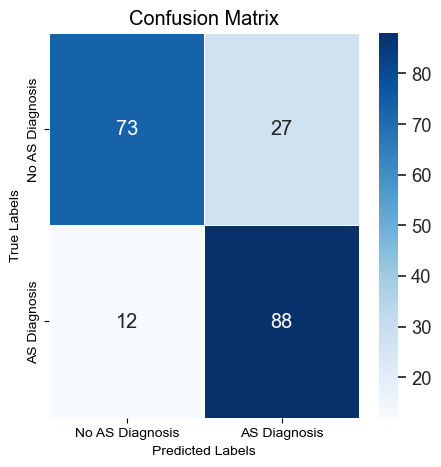

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix as heatmap
fig, ax = plt.subplots(figsize=(5,5))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, ax=ax)

# Labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# ✅ Corrected labels
ax.xaxis.set_ticklabels(["No AS Diagnosis", "AS Diagnosis"])
ax.yaxis.set_ticklabels(["No AS Diagnosis", "AS Diagnosis"])

# Show plot
plt.show()
